<a href="https://colab.research.google.com/github/c820306/Alpha_camp_recommentation/blob/main/A4_%E5%AF%A6%E4%BD%9C%E3%80%8CContent_based_Filtering%E3%80%8D%E7%9A%84%E6%8E%A8%E8%96%A6%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.匯入資料

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
import pandas as pd
import gzip, json
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 2.載入資料

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

In [ ]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata = getDF('./meta_All_Beauty.json.gz')
ratings = pd.read_csv('./All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
ratings.head(3)

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800


In [ ]:
metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


In [ ]:
print(metadata.shape)
print(ratings.shape)

(32892, 19)
(371345, 4)


 ## 3.資料清洗與EDA

In [ ]:
##去除重複資料
metadata = metadata.loc[metadata.astype(str).drop_duplicates().index]

In [ ]:
metadata_clean = metadata.drop(['category','tech1','fit','tech2','imageURL','imageURLHighRes','main_cat'],axis=1)

In [ ]:
metadata_clean.shape

(32488, 12)

In [ ]:
metadata_clean['ranking'] = metadata_clean['rank'].str.split(expand=True)[0]
metadata_clean['ranking'] = pd.to_numeric(metadata_clean['ranking'].str.replace(',',''))
# metadata_clean.loc[metadata_clean['ranking'].isnull().index, ['ranking']] = np.nan

In [ ]:
metadata_clean['sub_catagory'] = metadata_clean['rank'].str.split('in').str[1]
metadata_clean['sub_catagory'] = metadata_clean['sub_catagory'].str.replace(r'(','', regex=True)
metadata_clean['sub_catagory'] = metadata_clean['sub_catagory'].str.replace(r'&.*;','', regex=True)
metadata_clean['sub_catagory'] = metadata_clean['sub_catagory'].str.replace(r'&','', regex=True)

In [ ]:
# 檢視各子分類數量
metadata_clean['sub_catagory'].value_counts()

 Beauty  Personal Care       32015
 Grocery  Gourmet Food          37
 Health  Household              21
 Toys  Games                     3
 Sports  Outdoors                3
 Baby                            2
 Cloth                           2
 Tools  Home Improvement         1
 Automotive                      1
 Home  Kitchen                   1
Name: sub_catagory, dtype: int64

In [ ]:
# 僅Beauty  Personal Care數量最多，只保留 Beauty Personal Care 
metadata_clean = metadata_clean[metadata_clean['sub_catagory'] ==' Beauty  Personal Care ']
metadata_clean.reset_index(inplace=True, drop=True)

In [ ]:
# 清洗 metadata_clean['price']
metadata_clean['price_n'] = metadata_clean['price'].str.split('$', expand=True)[1]
metadata_clean['price_n'] = metadata_clean['price_n'].str.replace(',','')
metadata_clean['price_n'] = metadata_clean['price_n'].astype(float)

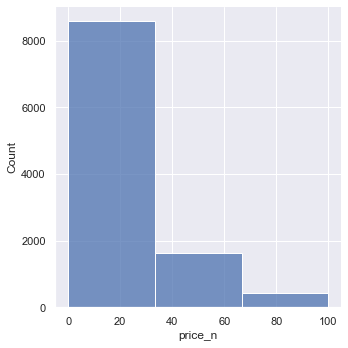

In [ ]:
# check the distribution of price, 
sns.displot(
    metadata_clean[metadata_clean['price_n']<100]['price_n'], bins = 3)

In [ ]:
# 將價格分類作為特徵值
def price_catagory(x):
    if np.isnan(x):
        return 'No_price'
    elif x <= 20:
        return 'Low'
    elif x > 20 and x <=40:
        return 'Middle'
    else:
        return 'High'
metadata_clean['price_catagory'] = metadata_clean['price_n'].apply(price_catagory)

<AxesSubplot:>

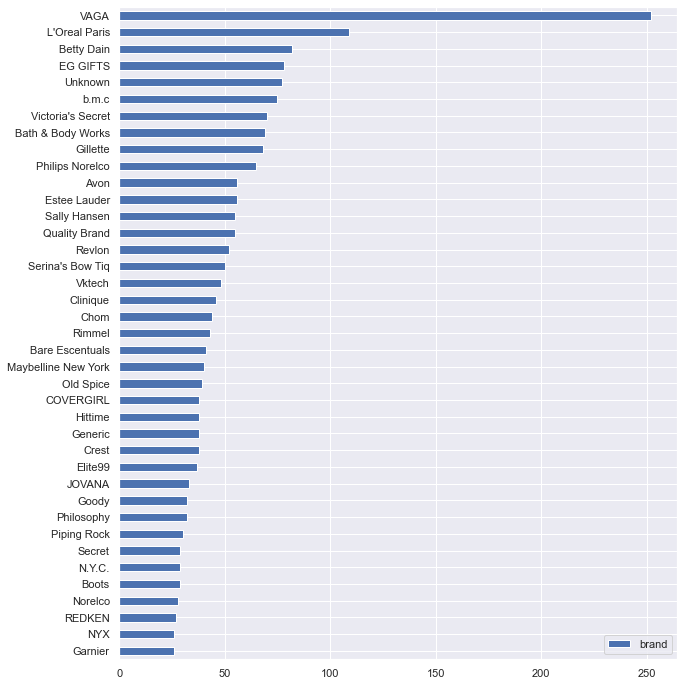

In [ ]:
# 檢視各品牌資料量
metadata_clean['brand'].value_counts(ascending=True).iloc[-40:-1].to_frame().plot(kind='barh',figsize=(10,12))

In [ ]:
# 檢查brand空值
print("number of empty brand: ", len(metadata_clean[metadata_clean['brand']== '']))
# brand空值補值
metadata_clean.loc[metadata_clean[metadata_clean['brand']== ''].index, 'brand'] = 'no_brand'

number of empty brand:  15388


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
metadata_clean['brand_n'] = labelencoder.fit_transform(metadata_clean['brand'])

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [ ]:
print("date range of rating: ", ratings['DATE'].min(),ratings['DATE'].max())

date range of rating:  2000-01-10 00:00:00 2018-10-02 00:00:00


In [ ]:
ratings['YYYYMM'] = ratings['DATE'].apply(lambda x : x.strftime("%Y-%m"))

<AxesSubplot:xlabel='YYYYMM'>

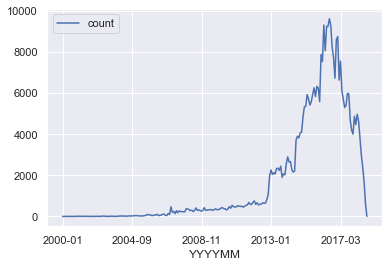

In [ ]:
## 每月銷售量有減少跡象
ratings.groupby(['YYYYMM']).agg(count =('asin','count')).plot()

In [ ]:
ratings.groupby(['YYYYMM']).agg(count =('asin','count')).T

YYYYMM,2000-01,2000-05,2000-06,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
count,1,1,1,1,4,5,3,4,4,4,...,4870,4470,4966,4644,3807,2978,2387,1662,590,3


## TF/IDF處理

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download("stopwords")
nltk.download('punkt')
stopword = stopwords.words('english')

[nltk_data] Downloading package punkt to /Users/c820306/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print("the number of stopword: ",len(stopword))
print(stopword[:10])

the number of stopword:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [ ]:
# 合併 title / description/ brand/ price 當作特徵值
def txt_clean(x):
    words = f'{x["title"]}, {" ".join(x["description"])}, {"".join(str(x["brand"]))}, {"".join(x["price_catagory"])}'
    words = words.lower()
    tokens = nltk.word_tokenize(words)  # --> return list
#     print("tokens", tokens)
    word_filter = [token for token in tokens if token not in stopword]
    #排除重複文字
    word_filter = list(set(word_filter))
    word_filter = " ".join(word_filter)
    return word_filter

In [ ]:
metadata_clean['title_description'] = metadata_clean.apply(txt_clean, axis =1)

In [ ]:
# 計算商品用標題所表示的 tfidf 矩陣
vectorizer = TfidfVectorizer(min_df = 100) ## min_df = 100 限制字頻>100
tfidf_matrix = vectorizer.fit_transform(metadata_clean['title_description'])

In [ ]:
tfidf_matrix.shape

(32015, 1503)

## 4.切割資料

In [ ]:
ratings_trainings = ratings[(ratings['DATE'] < '2018-09-01')]
ratings_testings = ratings[(ratings['DATE'] >= '2018-09-01') &  (ratings['DATE'] <= '2018-09-30')]

print("ratings_trainings1:", ratings_trainings.shape)
print("ratings_testings:", ratings_testings.shape)

ratings_trainings1: (370752, 6)
ratings_testings: (590, 6)


## 5.計算相似度

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

## 6.推薦系統

### A. Content-based

使用Content_based分析，將各testing user過去產品推薦k個商品，比較recall

In [ ]:
asin2index_mapping = pd.Series(metadata_clean.index,index = metadata_clean['asin'])  # title -> index, metadata_clean.index -> column

In [ ]:
# 產生資料
def create_ratings_data():
    
    ratings_trainings = ratings[(ratings['DATE'] < '2018-09-01')]
    ratings_testings = ratings[(ratings['DATE'] >= '2018-09-01') &  (ratings['DATE'] <= '2018-09-30')]
    ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records') #‘records’ : list like [{column -> value}, … , {column -> value}]
    ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
    testings_users = list(ratings_testings_by_user.keys())
    
    return ratings_trainings, ratings_testings, ratings_testings_by_user, testings_users


# 推薦相似產品
def recommend_similar_item(asin, k=2):
    
    try:
        item_index = asin2index_mapping[asin]
        # print("asin", asin)
        similarity_score = list(enumerate(similarity_matrix[item_index]))  
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        # print("similarity_score", similarity_score)
        item_indices = [i[0] for i in similarity_score]

        return (metadata_clean['asin'].iloc[item_indices].tolist())
        
    except:
        return []

# 每個客戶的推薦產品清單
def recommender(testings_users, ratings_trainings, k):
    
    recommend_dict_by_user = {}
    for user in testings_users:
        recommend_list_by_user = []
        # 找出測試集客戶過去有買的產品有哪些，藉此依據過去消費商品特徵推薦產品
        purchase_record_asin_list = metadata_clean[metadata_clean['asin'].isin(ratings_trainings[ratings_trainings['reviewerID']== user]['asin'].tolist())]['asin'].to_list()
        for asin in purchase_record_asin_list:
            recommend_list_by_user.extend(recommend_similar_item(asin, k))
        # print(user, recommend_list_by_user)
        recommend_dict_by_user[user] = recommend_list_by_user
    
    return recommend_dict_by_user


def evaluate(ratings_testings_by_user={}, recommend_dict_by_user={}):

    total = 0
    for d in ratings_testings_by_user:
        if d in recommend_dict_by_user:
            total += len(set(recommend_dict_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    
    return score

recommendation_nums = [2, 5, 10, 15, 20, 25, 30]

score_result_dict = {}

for k in recommendation_nums:
    score_result = []
    
    print(f"【每個商品找最相似{ k }個...】")
    ratings_trainings, ratings_testings, ratings_testings_by_user, testings_users = create_ratings_data()
    
    print("產出每個客戶推薦名單中...")
    recommend_dict_by_user = recommender(testings_users, ratings_trainings, k)
    print("產出每個客戶推薦名單：已完成")
    
    print("評估結果中...")
    score_result.append(evaluate(ratings_testings_by_user, recommend_dict_by_user))
    print(f"評估結果：已完成\n")
    score_result_dict[k] = score_result

score_result_df = pd.DataFrame(data = score_result_dict)


【每個商品找最相似2個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似5個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似10個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似15個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似20個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似25個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似30個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成



In [ ]:
score_result_df

,2,5,10,15,20,25,30
0,0.001695,0.001695,0.005085,0.005085,0.005085,0.005085,0.005085


### B. Content-based + Rule-based

#### 確認Ruled-based最合適參數

In [ ]:
 # 依時間區間產生資料區間，觀察推薦成效
def create_ratings_data_RB(start, end):
    
    ratings_trainings = ratings[(ratings['DATE'] >= start) & (ratings['DATE'] < end)]
    ratings_testings = ratings[(ratings['DATE'] >= '2018-09-01') &  (ratings['DATE'] <= '2018-09-30')]
    ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records') #‘records’ : list like [{column -> value}, … , {column -> value}]
    ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
    testings_users = list(ratings_testings_by_user.keys())
    
    return ratings_trainings, ratings_testings, ratings_testings_by_user, testings_users

# 產出推薦商品
def recommender_RB(ratings_trainings, k):    
    ## product_count
    ratings_compare = ratings_trainings.groupby(['asin'], as_index=False).agg(product_count=("asin", 'count'),avg_rating=("overall", 'mean'), nearest_date=('DATE','max'))
    rating_sorting = ratings_compare.sort_values(by=['product_count'], ascending=(False))
    rating_sorting['ranking'] = rating_sorting['product_count'].rank(ascending=False)
    rating_sorting.reset_index(drop=True, inplace=True)
    recom = rating_sorting['asin'].tolist()[:k]
    return recom

# 計算recall
def evaluate_RB(recom , recommend_dict_by_user={}): 

    total = 0
    for d in ratings_testings_by_user.keys():
        total += len(set(recom)& set(ratings_testings_by_user[d]))
    score = total / len(ratings_testings)    
    return score


from dateutil.relativedelta import relativedelta

month_ranges = [1 if i == 0 else i*3 for i in range(0,13)]
end = pd.datetime(2018, 9, 1).strftime("%Y-%m-%d")
start_list = [(pd.datetime(2018, 9, 1)- relativedelta(months= month)).strftime("%Y-%m-%d") for month in month_ranges]
period_range = [[start, end] for start in start_list]

recommendation_nums = [2, 5, 10, 15, 20, 25, 30]
score_result_dict = {}

for k in recommendation_nums:
    print(f"【每個商品找最相似{ k }個...】")
    score_result = []
    for period in period_range:
#         print(f"檢視{period}區間\n")
        ratings_trainings, ratings_testings, ratings_testings_by_user, testings_users = create_ratings_data_RB(period[0], period[1])
        recom = recommender_RB(ratings_trainings, k)
        score_result.append(evaluate_RB(recom , recommend_dict_by_user))
#         print(f"評估結果：已完成, score: {evaluate_RB(recom , recommend_dict_by_user)}\n")
        
    score_result_dict[k] = score_result
        
score_result_df = pd.DataFrame(data = score_result_dict ,index= [f'{period[0]} - {period[1]}' for period in period_range])



【每個商品找最相似2個...】


<ipython-input-37-1ebfe81b5207>:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2018, 9, 1).strftime("%Y-%m-%d")
<ipython-input-37-1ebfe81b5207>:31: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_list = [(pd.datetime(2018, 9, 1)- relativedelta(months= month)).strftime("%Y-%m-%d") for month in month_ranges]


【每個商品找最相似5個...】
【每個商品找最相似10個...】
【每個商品找最相似15個...】
【每個商品找最相似20個...】
【每個商品找最相似25個...】
【每個商品找最相似30個...】


In [ ]:
score_result_df

,2,5,10,15,20,25,30
2018-08-01 - 2018-09-01,0.083051,0.088136,0.154237,0.169492,0.193220,0.235593,0.264407
2018-06-01 - 2018-09-01,0.083051,0.098305,0.133898,0.154237,0.203390,0.216949,0.249153
2018-03-01 - 2018-09-01,0.083051,0.096610,0.096610,0.116949,0.123729,0.150847,0.150847
2017-12-01 - 2018-09-01,0.083051,0.096610,0.098305,0.115254,0.123729,0.123729,0.130508
2017-09-01 - 2018-09-01,0.083051,0.096610,0.098305,0.098305,0.105085,0.127119,0.130508
2017-06-01 - 2018-09-01,0.083051,0.083051,0.098305,0.098305,0.098305,0.123729,0.140678
2017-03-01 - 2018-09-01,0.083051,0.083051,0.096610,0.098305,0.100000,0.108475,0.125424
2016-12-01 - 2018-09-01,0.083051,0.083051,0.096610,0.098305,0.098305,0.100000,0.125424
2016-09-01 - 2018-09-01,0.083051,0.083051,0.083051,0.098305,0.098305,0.100000,0.113559
2016-06-01 - 2018-09-01,0.083051,0.083051,0.083051,0.096610,0.098305,0.098305,0.106780


結論： rule-based的時間區間與推薦數， 選擇時間區間：'2018-08-01 - 2018-09-01' 、 k=30

#### 製作兩者content_based 與 rule_based之推薦系統

In [ ]:
def rule_based(start= '2018-08-01',end ='2018-09-01', k=30):
    
    ratings_trainings = ratings[(ratings['DATE'] >= start) & (ratings['DATE'] < end)]
    ratings_testings = ratings[(ratings['DATE'] >= '2018-09-01') &  (ratings['DATE'] <= '2018-09-30')]
    ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records') #‘records’ : list like [{column -> value}, … , {column -> value}]
    ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
    testings_users = list(ratings_testings_by_user.keys())
        
    ## product_count
    ratings_compare = ratings_trainings.groupby(['asin'], as_index=False).agg(product_count=("asin", 'count'),avg_rating=("overall", 'mean'), nearest_date=('DATE','max'))
    rating_sorting = ratings_compare.sort_values(by=['product_count'], ascending=(False))
    rating_sorting['ranking'] = rating_sorting['product_count'].rank(ascending=False)
    rating_sorting.reset_index(drop=True, inplace=True)
    recom = rating_sorting['asin'].tolist()[:k]
    return recom


In [ ]:
# 產生資料
def create_ratings_data():
    
    ratings_trainings = ratings[(ratings['DATE'] < '2018-09-01')]
    ratings_testings = ratings[(ratings['DATE'] >= '2018-09-01') &  (ratings['DATE'] <= '2018-09-30')]
    ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records') #‘records’ : list like [{column -> value}, … , {column -> value}]
    ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
    testings_users = list(ratings_testings_by_user.keys())
    
    return ratings_trainings, ratings_testings, ratings_testings_by_user, testings_users


# 推薦相似產品
def recommend_similar_item(asin, k=2):
    
    try:
        item_index = asin2index_mapping[asin]
        # print("asin", asin)
        similarity_score = list(enumerate(similarity_matrix[item_index]))  
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        # print("similarity_score", similarity_score)
        item_indices = [i[0] for i in similarity_score]

        return (metadata_clean['asin'].iloc[item_indices].tolist())
        
    except:
        return []

# 每個客戶的推薦產品清單
def recommender(testings_users, ratings_trainings, k):
    
    recommend_dict_by_user = {}
    for user in testings_users:
        recommend_list_by_user = []
        
        # 找出測試集客戶過去有買的產品有哪些，藉此依據過去消費商品特徵推薦產品
        purchase_record_asin_list = metadata_clean[metadata_clean['asin'].isin(ratings_trainings[ratings_trainings['reviewerID']== user]['asin'].tolist())]['asin'].to_list()
        for asin in purchase_record_asin_list:
            recommend_list_by_user.extend(recommend_similar_item(asin, k))
        
        if recommend_list_by_user == []: # content-based 
            recom = rule_based(start= '2018-08-01',end ='2018-09-01', k=30)
            recommend_dict_by_user[user] = recom
        else:  # rule-based 
            recommend_dict_by_user[user] = recommend_list_by_user
    
    return recommend_dict_by_user

# 計算recall
def evaluate(ratings_testings_by_user={}, recommend_dict_by_user={}):

    total = 0
    for d in ratings_testings_by_user:
        if d in recommend_dict_by_user:
            total += len(set(recommend_dict_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    
    return score


recommendation_nums = [2, 5, 10, 15, 20, 25, 30]
score_result_dict = {}

for k in recommendation_nums:
    score_result = []
    
    print(f"【每個商品找最相似{ k }個...】")
    ratings_trainings, ratings_testings, ratings_testings_by_user, testings_users = create_ratings_data()
    
    print("產出每個客戶推薦名單中...")
    recommend_dict_by_user = recommender(testings_users, ratings_trainings, k)
    print("產出每個客戶推薦名單：已完成")
    
    print("評估結果中...")
    score_result.append(evaluate(ratings_testings_by_user, recommend_dict_by_user))
    print(f"評估結果：已完成\n")
    score_result_dict[k] = score_result

score_result_df = pd.DataFrame(data = score_result_dict)


【每個商品找最相似2個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似5個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似10個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似15個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似20個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似25個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成

【每個商品找最相似30個...】
產出每個客戶推薦名單中...
產出每個客戶推薦名單：已完成
評估結果中...
評估結果：已完成



In [ ]:
score_result_df

,2,5,10,15,20,25,30
0,0.252542,0.252542,0.255932,0.255932,0.255932,0.255932,0.255932


## 7. Conclusion

>1. 僅38位於9月前有購買產品，若單純以conten-based去做推薦，最好的recall分數僅為 0.005085，因此決定結合rule-based做推薦

>2. rule-based先透過時間/推薦產品數雙維度找出最適參數測試，選出時間區間：'2018-08-01 - 2018-09-01' 、 k=30，其recall表現最佳，可達 0.264407

>3. conten-based & rule-based 結果中， conten-based從不同產品數推薦的recall中，差異不大，主要落在0.252542~ 0.255932，整體表現也比第一次作業佳。